In [1]:
pip install --upgrade datasets tokenizers huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install vaderSentiment

In [3]:
!pip install transformers datasets

In [4]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install transformers[torch]

In [6]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install imbalanced-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [9]:
!python --version

Python 3.10.16


In [11]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------------------ --- 1.6/1.7 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 11.7 MB/s eta 0:00:00


In [12]:
!pip install tensorflow

In [14]:
pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('movie_reviews')
nltk.download('punkt')

# Load the dataset
file_path = 'SMDM_Project_DataSet_V1.csv'
df = pd.read_csv(file_path)

# Convert 'updated_at' to datetime format
df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce')

# Feature Engineering
# 1. Post Title Length
df['title_length'] = df['title'].apply(lambda x: len(str(x)) if x is not None else 0)

# 2. Post Content Length (selftext)
df['selftext_length'] = df['selftext'].apply(lambda x: len(str(x)) if x is not None else 0)

# 3. Sentiment Score (Title + Selftext)
analyzer = SentimentIntensityAnalyzer()
df['title_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['selftext_sentiment'] = df['selftext'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'] if pd.notna(x) else 0)

# 4. Upvotes
df['upvotes'] = df['updated_ups']

# 5. Gilded
df['gilded'] = df['gilded']

# 6. Engagement Velocity
df = df.sort_values(by='updated_at')
df['upvote_diff'] = df['updated_ups'].diff()
df['time_diff'] = df['updated_at'].diff().dt.total_seconds() / 3600
df['engagement_velocity'] = df['upvote_diff'] / df['time_diff']
df['engagement_velocity'] = df['engagement_velocity'].replace([float('inf'), -float('inf')], 0).fillna(0)

# 7. Post Popularity Index
df['time_since_posting'] = (df['updated_at'] - df['updated_at'].min()).dt.total_seconds() / 3600
df['popularity_index'] = (df['updated_ups'] + df['gilded']) / df['time_since_posting']
df['popularity_index'] = df['popularity_index'].replace([float('inf'), -float('inf')], 0).fillna(0)

# 8. Time of Post
df['hour_of_post'] = df['updated_at'].dt.hour
df['day_of_week'] = df['updated_at'].dt.dayofweek
df['month_of_post'] = df['updated_at'].dt.month

# 9. Author Cakeday
df['author_cakeday'] = df['author_cakeday'].apply(lambda x: 1 if pd.notna(x) else 0)

# 10. Link Flair Type
df['link_flair_type'] = df['link_flair_richtext'].apply(lambda x: len(str(x)))

# 11. Is Gallery
df['is_gallery'] = df['is_gallery'].apply(lambda x: 1 if pd.notna(x) else 0)

# 12. Is Crosspost
df['is_crosspost'] = df['crosspost_parent'].apply(lambda x: 1 if pd.notna(x) else 0)

# 13. Upvote to Gilded Ratio
df['upvote_to_gilded_ratio'] = df['updated_ups'] / (df['gilded'] + 1)
df['upvote_to_gilded_ratio'] = df['upvote_to_gilded_ratio'].replace([float('inf'), -float('inf')], 0).fillna(0)

# 14. Define Target Variable: is_viral
threshold_upvotes = 500  # Adjusted to balance classes; tune as needed
df['is_viral'] = df['updated_ups'].apply(lambda x: 1 if x >= threshold_upvotes else 0)

# Clean Dataset
df = df.drop_duplicates(subset=['title'])
df = df[df['title'].str.len() >= 5]

# Check Class Distribution
viral_posts = df['is_viral'].sum()
non_viral_posts = len(df) - viral_posts
imbalance_ratio = non_viral_posts / viral_posts if viral_posts > 0 else float('inf')
print(f"Number of viral posts (is_viral = 1): {viral_posts}")
print(f"Number of non-viral posts (is_viral = 0): {non_viral_posts}")
print(f"Imbalance ratio (non-viral to viral): {imbalance_ratio:.2f}")


C:\Users\adiun\anaconda3\envs\new_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adiun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\adiun\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adiun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\adiun\AppData\Local\Temp\ipykernel_6888\1296786633.py:21: DtypeWarning: Columns (41,82,97) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of viral posts (is_viral = 1): 662
Number of non-viral posts (is_viral = 0): 8472
Imbalance ratio (non-viral to viral): 12.80


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adiun\AppData\Local\Temp\ipykernel_6888\2131650987.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.117100,0.184027,0.941281,0.942469,0.904550,0.983705
2,0.062500,0.122137,0.975804,0.975811,0.954414,0.998189
3,0.083100,0.090710,0.983476,0.983383,0.967309,1.000000
4,0.038200,0.128632,0.981115,0.981054,0.962812,1.000000
5,0.000100,0.155269,0.979640,0.979604,0.960023,1.000000


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1732
           1       0.97      1.00      0.98      1657

    accuracy                           0.98      3389
   macro avg       0.98      0.98      0.98      3389
weighted avg       0.98      0.98      0.98      3389



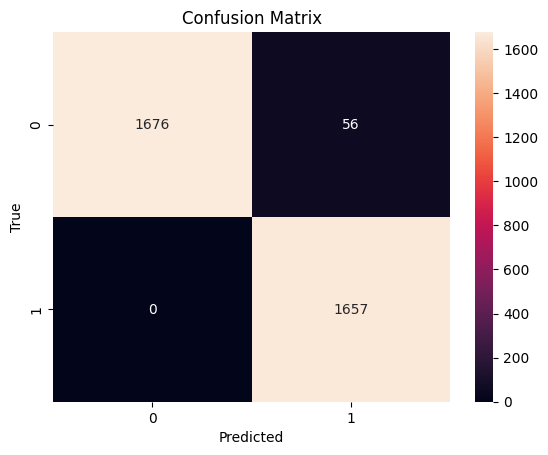

Misclassified examples (text, predicted, true):
Text: Russia's Putin says it would be a 'profound mistake' to dismiss Trump's push for Greenland, Predicted: 1, True: 0
Text: American flight to China forced to turn around after pilot forgets passport, Predicted: 1, True: 0
Text: PM Modi's outreach to Putin helped prevent 'potential nuclear attack' on Ukraine, Predicted: 1, True: 0
Text: Growing up in the 90’s, Predicted: 1, True: 0
Text: Stay starring Ryan gosling is one of the best movies no one's heard of., Predicted: 1, True: 0


In [2]:
# Handle Class Imbalance with Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['title']], df['is_viral'])
df_resampled = pd.DataFrame({'title': X_resampled['title'], 'is_viral': y_resampled})

# Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_resampled['title'].tolist(), df_resampled['is_viral'].tolist(), test_size=0.2, random_state=42
)

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create Datasets
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': train_labels
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': test_labels
})

# Load Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    learning_rate=2e-5,
    save_strategy="epoch",
    eval_strategy="epoch",  # Updated from evaluation_strategy
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(-1)
print("Classification Report:")
print(classification_report(test_labels, preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Inspect Misclassifications
misclassified = [(text, pred, label) for text, pred, label in zip(test_texts, preds, test_labels) if pred != label]
print("Misclassified examples (text, predicted, true):")
for text, pred, label in misclassified[:5]:
    print(f"Text: {text}, Predicted: {pred}, True: {label}")